# Screened infeasibility analysis
Once a parameter screening analysis has been performed and detailed SA/UQ evaluated on the most influential uncertain parameters, this notebook analyses the results using a pre-existing database, created in the `feas_screened_eval.ipynb` notebook. This is capable of running locally, as there are only 3 uncertain parameters.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from infeas import analyse

In [2]:
campaign, samples = analyse.read_campaign(campaign_name="example_local")
samples

Reading in campaign database.
Campaign read in. Number of samples = 250


,run_id,iteration,step_ucsc_0,step_ref_69,step_ucblbe,fdene,hfact,coreradius,fimp_2,fimp_14,...,pinjalw,alstroh,sig_tf_wp_max,aspect,boundu_2,triang,vary_param,startupratio,step_cconshtf,cdirt
0,1,0,1954.917438,8.462036,8874.026740,1.2,1.2,0.75,0.1,0.00001,...,61.0,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,91.0,35086.0
1,2,0,1935.554938,8.462036,8874.026740,1.2,1.2,0.75,0.1,0.00001,...,61.0,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,91.0,35072.0
2,3,0,1954.917438,18.869750,8874.026740,1.2,1.2,0.75,0.1,0.00001,...,61.0,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,91.0,36307.0
3,4,0,1954.917438,8.462036,6684.669708,1.2,1.2,0.75,0.1,0.00001,...,61.0,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,91.0,31831.0
4,5,0,1935.554938,18.869750,6684.669708,1.2,1.2,0.75,0.1,0.00001,...,61.0,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,91.0,33038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246,0,741.154394,14.595833,4703.471327,1.2,1.2,0.75,0.1,0.00001,...,61.0,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,91.0,28713.0
246,247,0,1311.740715,14.595833,4703.471327,1.2,1.2,0.75,0.1,0.00001,...,61.0,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,91.0,29132.0
247,248,0,741.154394,20.612427,4703.471327,1.2,1.2,0.75,0.1,0.00001,...,61.0,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,91.0,29418.0
248,249,0,741.154394,14.595833,12315.152711,1.2,1.2,0.75,0.1,0.00001,...,61.0,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,91.0,40030.0


## Analysis

Check out the QOIs from the samples.

In [3]:
qois = [
    "cdirt"
]
samples[qois].describe()

,cdirt
count,250.000000
mean,38652.264000
std,5744.491284
min,27999.000000
25%,34626.250000
50%,39206.000000
75%,43666.750000
max,47410.000000


### Most violated constraints

Find the most violated constraints (by mean).

Plotting violated constraint means.


Text(0, 0.5, 'Constraint')

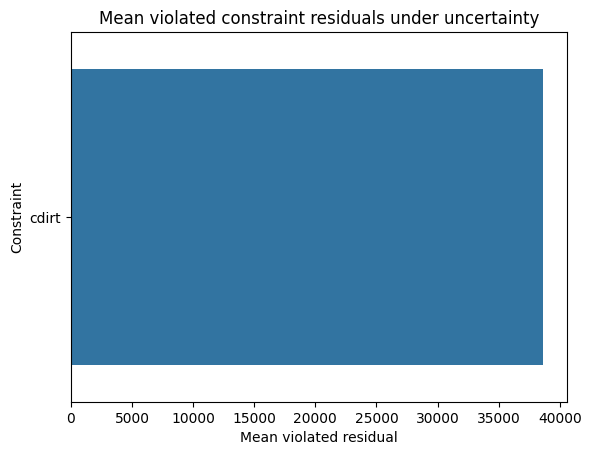

In [4]:
print("Plotting violated constraint means.")
# Get absolute values of violated constraint residuals
# Abs values before mean: be fair to eq constraints (either side of 0)
vio_means_series = samples[qois].abs().mean().sort_values(ascending=False)
vio_means = pd.DataFrame(vio_means_series, columns=["mean"])
vio_means["variable"] = vio_means.index
vio_means.reset_index(drop=True)

# Exclude objf and vio-constr_res
filter_qois = ["norm_objf", "rms_vio_constr_res"]
constrs_mask = ~vio_means["variable"].isin(filter_qois)
vio_means_filt = vio_means[constrs_mask]

# Plot
fig, ax = plt.subplots()
sns.barplot(data=vio_means_filt, x="mean", y="variable", ax=ax)
ax.set_title("Mean violated constraint residuals under uncertainty")
ax.set_xlabel("Mean violated residual")
ax.set_ylabel("Constraint")
# fig.savefig("mean_vio_constr_res.png")

Most violated by frequency. Tricky to set a threshold: probably not the best.

Plotting constraint violation freqencies.


Text(0, 0.5, 'Constraint')

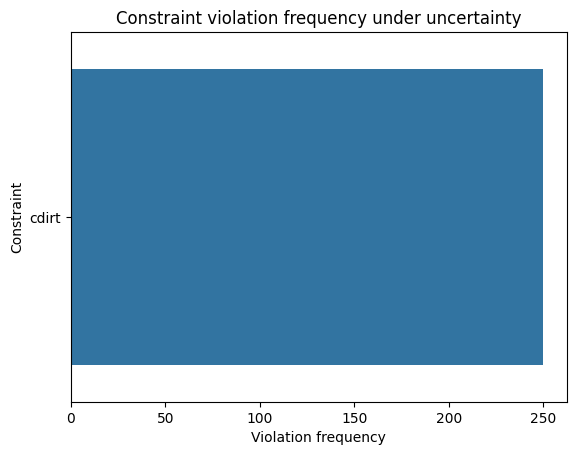

In [5]:
print("Plotting constraint violation freqencies.")
constr_tol = 1e-3
vio_counts = {}
for qoi in qois:
    # Count rows (samples) where each constraint is violated
    vio_count = samples[samples[qoi].abs() > constr_tol].shape[0]
    vio_counts[qoi] = vio_count

vio_counts
vio_counts_df = pd.DataFrame(data=vio_counts, index=[0])

vio_counts_df_melt = vio_counts_df.melt()
vio_counts_df_melt = vio_counts_df_melt.sort_values(by="value", ascending=False)
vio_counts_df_melt.reset_index(drop=True)
vio_counts_df_melt_filt = vio_counts_df_melt[
    ~vio_counts_df_melt["variable"].isin(filter_qois)
]

# # Plot
fig, ax = plt.subplots()
sns.barplot(data=vio_counts_df_melt_filt, x="value", y="variable", ax=ax)
ax.set_title("Constraint violation frequency under uncertainty")
ax.set_xlabel("Violation frequency")
ax.set_ylabel("Constraint")
# fig.savefig("vio_constr_res_freq.png")

### Distribution of violated constraint residuals

In [6]:
print("Plotting distribution of violated constraint residuals.")
# Analyse a single output variable, vio_constr_res
results = campaign.analyse(qoi_cols=["cdirt"])

# Get its distribution
dist = results.get_distribution(qoi="cdirt")

# Locations for density function to be evaluated
# (This is taken from easyvvuq's fusion tutorial)
x = np.linspace(dist.lower[0], dist.upper[0], num=500)
pdf = dist.pdf(x)

# Plot
fig, ax = plt.subplots()
sns.lineplot(x=x, y=pdf, markers=True, ax=ax)
ax.set_title("Distribution for rms_vio_constr_res")
ax.set_xlabel("RMS of violated constraint residuals")
ax.set_ylabel("Probability density")
ax.set_xlim([0.0, None])
# fig.savefig("vio_constr_res_dist.png")

Plotting distribution of violated constraint residuals.


NotImplementedError: 

### Distribution of individual constraint violations

In [ ]:
print("Plotting top 3 violated constraint distributions")
# Take top 3 violated contraints (by mean)
vio_means_filt = vio_means_filt.reset_index(drop=True)
top_vio_means = vio_means_filt[0:3]["variable"].to_list()

# Analyse a single output variable, vio_constr_res
results = campaign.analyse(qoi_cols=top_vio_means)

# Get the distributions
dists = []
dist_lowest = 0.0
dist_highest = 0.0
for qoi in top_vio_means:
    dist = results.get_distribution(qoi=qoi)
    if dist.lower[0] < dist_lowest:
        dist_lowest = dist.lower[0]
    if dist.upper[0] > dist_highest:
        dist_highest = dist.upper[0]
    dists.append(dist)

# Locations for density function to be evaluated
x = np.linspace(dist_lowest, dist_highest, num=500)

# Flip x to make +ve
pdfs = {"x": -x}
for constr_name, dist in zip(top_vio_means, dists):
    pdfs[constr_name] = dist.pdf(x)

top_vio_means_df = pd.DataFrame(pdfs)
top_vio_means_df
top_vio_means_df_melt = top_vio_means_df.melt(id_vars="x", value_vars=top_vio_means)
top_vio_means_df_melt
# Plot
fig, ax = plt.subplots()
sns.lineplot(
    data=top_vio_means_df_melt, x="x", y="value", hue="variable", markers=True, ax=ax
)
ax.set_title("Distribution of top 3 violated constraints")
ax.set_xlabel("Violated constraint value")
ax.set_ylabel("Probability density")
ax.set_xlim([0.0, None])
# fig.savefig("top_3_vio_constr_res_dist.png")

### Objective function

In [ ]:
print("Plotting objective function distribution")
# Analyse a single output variable, vio_constr_res
results = campaign.analyse(qoi_cols=["cdirt"])

# Get its distribution
dist = results.get_distribution(qoi="cdirt")

# Locations for density function to be evaluated
x = np.linspace(dist.lower[0], dist.upper[0], num=500)
pdf = dist.pdf(x)

# Plot
fig, ax = plt.subplots()
sns.lineplot(x=x, y=pdf, markers=True, ax=ax)
ax.set_title("Distribution for cdirt")
ax.set_xlabel("cdirt")
ax.set_ylabel("Probability density")
# fig.savefig("objf_dist.png")

## Sobol indices

### Violated constraint residuals

Sobols for violated constraint residuals.

In [ ]:
print("Plotting Sobols for violated constraint residuals.")
results = campaign.analyse(qoi_cols=["cdirt"])
fig, ax = plt.subplots()
results.plot_sobols_treemap("cdirt", figsize=(10, 10), ax=ax)
# Can get a ZeroDivisionError in plot_sobols_treemap() if a Sobol index is 0
# fig.savefig("vio_constr_res_sobols_treemap.png")

### Sobols for individual constraint

Interesting for discussion, but not for poster. Too much information (Sobol indices for each constraint).

In [ ]:
print("Plotting individual constraint Sobols")
results = campaign.analyse(qoi_cols=top_vio_means)
for constr_name in top_vio_means:
    fig, ax = plt.subplots()
    try:
        results.plot_sobols_treemap(constr_name, ax=ax)
        # fig.savefig(f"{constr_name}_sobols_treemap.png")
        print(f"Plotted {constr_name} Sobols.")
    except:
        print(f"Couldn't plot {constr_name} Sobols.")

## Barplot of Sobol indices

In [ ]:
print("Plotting barplot of Sobols for direct cost.")
# results.sobols_first()
# results.sobols_second()
# results.sobols_total()

results = campaign.analyse(qoi_cols=["cdirt"])
sobols_first = results.sobols_first()["cdirt"]
sobols_first_df = pd.DataFrame(sobols_first)
sobols_first_df_melted = sobols_first_df.melt()
sobols_first_df_melted

fig, ax = plt.subplots()
sns.barplot(data=sobols_first_df_melted, x="value", y="variable", ax=ax)
ax.set_title("First-order Sobol indices for direct cost")
ax.set_xlabel("First-order Sobol index")
ax.set_ylabel("Uncertain input")
# fig.savefig("fo_sobols_bar.png")

In [ ]:
print("Plotting first and higher-order Sobols for direct cost.")
sobols_total = results.sobols_total()["cdirt"]

# Calculate higher-order Sobol indices
sobols_higher = {}
for key in sobols_first:
    sobols_higher[key] = sobols_total[key] - sobols_first[key]

# Combine first and higher-order into df
sobols_first_and_higher = {}
for key in sobols_first:
    sobols_first_and_higher[key] = [sobols_first[key][0], sobols_higher[key][0]]

sobols_first_and_higher_df = pd.DataFrame(
    sobols_first_and_higher, index=["First-order", "Higher-order"]
)
sobols_first_and_higher_df = sobols_first_and_higher_df.reset_index()
sobols_first_and_higher_df
sobols_first_and_higher_df_melted = sobols_first_and_higher_df.melt(id_vars="index")
sobols_first_and_higher_df_melted

# Plot
fig, ax = plt.subplots()
ax = sns.barplot(
    data=sobols_first_and_higher_df_melted,
    x="value",
    y="variable",
    hue="index",
    orient="h",
)
ax.set_title("First- and higher-order Sobol indices for direct cost")
ax.set_xlabel("Sobol index")
ax.set_ylabel("Uncertain input")
# fig.savefig("fo_ho_sobols_bar.png")